Прообраз: https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb

In [72]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

BATCH_ADRESS = 'batches_news'

print(artm.version())

0.10.0


In [73]:
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [74]:
dictionary = artm.Dictionary()

# Количесвто тем
topic_count = 3

model_plsa = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    cache_theta=True,
    #class_ids={'text': 1.0},
)

model_artm = artm.ARTM(
    topic_names=['topic_{}'.format(i) for i in range(topic_count)],
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    regularizers=[
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta', 
            tau=-0.15
        )
    ],
    cache_theta=True,
    #class_ids={'text': 1.0},
)

In [75]:
if os.path.isfile(BATCH_ADRESS + '/dictionary.dict'):
    os.remove(BATCH_ADRESS + '/dictionary.dict')
    
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=BATCH_ADRESS + '/dictionary.dict')

dictionary.load(dictionary_path=BATCH_ADRESS + '/dictionary.dict')

In [76]:
print(dictionary)

artm.Dictionary(name=11af2dd3-da61-40e6-9e2e-0540801ff71b, num_entries=39965)


In [60]:
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

In [61]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

In [62]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [63]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

In [64]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Sparsity Phi: 0.000 (PLSA) vs. 0.419 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.584 (PLSA) vs. 0.765 (ARTM)
Kernel purity: 0.780 (PLSA) vs. 0.798 (ARTM)
Perplexity: nan (PLSA) vs. nan (ARTM)


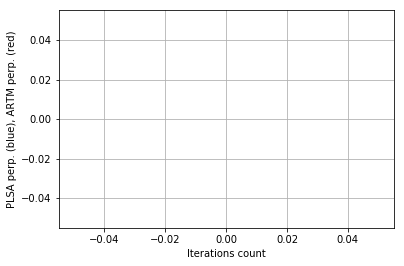

In [65]:
def print_measures(model_plsa, model_artm):
    print(
        'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['SparsityPhiScore'].last_value,
            model_artm.score_tracker['SparsityPhiScore'].last_value
        )
    )

    print(
        'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['SparsityThetaScore'].last_value,
            model_artm.score_tracker['SparsityThetaScore'].last_value
        )
    )

    print(
        'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
            model_artm.score_tracker['TopicKernelScore'].last_average_contrast
        )
    )

    print(
        'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
            model_artm.score_tracker['TopicKernelScore'].last_average_purity
        )
    )

    print(
        'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
            model_plsa.score_tracker['PerplexityScore'].last_value,
            model_artm.score_tracker['PerplexityScore'].last_value
        )
    )

    plt.plot(
        range(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
        range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2
    )
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

In [66]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [67]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [68]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

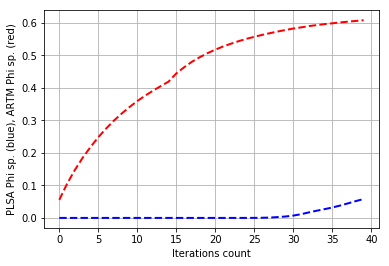

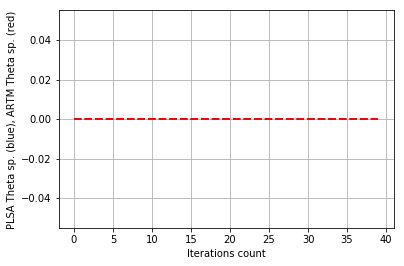

In [69]:
plt.plot(range(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [70]:
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ',)
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['быть', 'дело', 'который', 'этот', 'мочь', 'такой']
topic_1: 
['статья', 'задерживать', 'который', 'дело', 'человек', 'сотрудник']
topic_2: 
['быть', 'который', 'говорить', 'адвокат', 'этот', 'свой']


In [71]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ',)
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['быть', 'дело', 'этот', 'который', 'мочь', 'такой']
topic_1: 
['статья', 'задерживать', 'человек', 'рассказывать', 'сотрудник', 'часть']
topic_2: 
['быть', 'который', 'говорить', 'адвокат', 'этот', 'свой']
